# Notebook for generating and evaluating saliency maps

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle

import modules.dataset_configs as dc
from modules.classifier_modules import UnivarTSClfDataModule
from modules.classifier_modules import LSTMClf, LSTMClf_SaliencyGuidedTraining, AttentionLSTM
from modules.classifier_modules import CNNClf, CNNClf_SaliencyGuidedTraining, BasicTCN

from modules import helpers, functions

helpers.seed(1)

Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1


### Define classifier + experiment and extract dataset

In [2]:
# replace by desired experiment and classifier

experiment = dc.config_Experiment1
classifier = AttentionLSTM

save_location = "../results/saliency/"+ classifier.__name__ + "_" + experiment.__name__[7:] + "/"
plot_location = "../results/plots_saliency/" + classifier.__name__ + "_" + experiment.__name__[7:] + "/"
model_location = "../models/"


In [3]:
model_name = classifier.__name__ + "_" + experiment.__name__[7:]
checkpointpath = model_location + model_name + "/" + model_name + "_checkpoints.ckpt"
model = classifier.load_from_checkpoint(checkpointpath)

config = experiment()
dm = UnivarTSClfDataModule(
    seq_len = config['seq_len'],
    batch_size = model.hparams['batch_size'],
    simulator = config['simulator'],
    train_size = config['train_size'],
    val_size = config['val_size'],
    test_size = config['test_size'],
    num_workers = 8                                  
)
        
train_df, val_df, test_df, train_pred, val_pred, test_pred = helpers.get_sampled_data(dm, model)

Global seed set to 1


In [4]:
correct = np.where(test_df["label"]==test_pred)[0]
wrong = np.where(test_df["label"]!=test_pred)[0]
class1 = np.where(test_df["label"]==1)[0]
class0 = np.where(test_df["label"]==0)[0]

true_class1 = np.intersect1d(correct, class1)
true_class0 = np.intersect1d(correct, class0)

T1_instances = test_df.iloc[true_class1]
T0_instances = test_df.iloc[true_class0]

cleantestsets = pd.concat([T0_instances,T1_instances], ignore_index=True)

mean_signal_test = test_df.iloc[:,test_df.columns != "label"].mean(axis = 0)

### Create and save saliency scores

In [8]:
# calculate feature attribution of all correctly classified test data

with torch.no_grad():
    test_instances = test_df.loc[:,test_df.columns != "label"]
    instances = test_instances.to_numpy().reshape(np.shape(test_instances)[0], np.shape(test_instances)[1], -1) 
    instances = torch.Tensor(instances)

    attributions_IG = helpers.get_feature_attribution(instances, model,"IG").view(np.shape(test_instances)).numpy()
    attributions_SHAP = helpers.get_feature_attribution(instances, model,"SHAP").view(np.shape(test_instances)).numpy()
    attributions_DL = helpers.get_feature_attribution(instances, model,"DL").view(np.shape(test_instances)).numpy()
    attributions_LIME = helpers.get_feature_attribution(instances, model,"LIME").view(np.shape(test_instances)).numpy()
   
    with open(save_location + 'attributions_IG.pkl', 'wb') as f:
        pickle.dump(attributions_IG, f)

    with open(save_location + 'attributions_SHAP.pkl', 'wb') as f:
        pickle.dump(attributions_SHAP, f)

    with open(save_location + 'attributions_DL.pkl', 'wb') as f:
        pickle.dump(attributions_DL, f)

    with open(save_location + 'attributions_LIME.pkl', 'wb') as f:
        pickle.dump(attributions_LIME, f)

In [9]:
attribution_IG_df = pd.DataFrame(attributions_IG)
attribution_IG_df["label"] = test_pred

attribution_SHAP_df = pd.DataFrame(attributions_SHAP)
attribution_SHAP_df["label"] = test_pred

attribution_DL_df = pd.DataFrame(attributions_DL)
attribution_DL_df["label"] = test_pred

attribution_LIME_df = pd.DataFrame(attributions_LIME)
attribution_LIME_df["label"] = test_pred

### Plot saliency maps

#### a) Post-hoc attribution methods

In [ ]:
for i in range(len(T1_instances)):
    plt.figure()
    helpers.plot_heatmap_background(T1_instances.iloc[i,T1_instances.columns != "label"].values, attributions_IG[true_class1[i]], 
    title = "%s: Attribution heatmap correctly classified class 1 (IG)" % str(model_name), path = plot_location + "Attribution heatmap T1 (IG) %s.jpg" % str(i))

for i in range(len(T0_instances)):
    helpers.plot_heatmap_background(T0_instances.iloc[i,T0_instances.columns != "label"].values, attributions_IG[true_class0[i]], 
    title = "%s: Attribution heatmap correctly classified class 0 (IG)" % str(model_name), path = plot_location + "Attribution heatmap T0 (IG) %s.jpg" % str(i))
    plt.show()

In [ ]:
for i in range(len(T1_instances)):
    plt.figure()
    helpers.plot_heatmap_background(T1_instances.iloc[i,T1_instances.columns != "label"].values, attributions_SHAP[true_class1[i]], 
    title = "%s: Attribution heatmap correctly classified class 1 (SHAP)" % str(model_name), path = plot_location + "Attribution heatmap T1 (SHAP) %s.jpg" % str(i))
    #plt.savefig(plot_location + "Attribution heatmap T1 (SHAP) %s.jpg" % str(i))
    plt.show()
    

for i in range(len(T0_instances)):
    helpers.plot_heatmap_background(T0_instances.iloc[i,T0_instances.columns != "label"].values, attributions_SHAP[true_class0[i]], 
    title = "%s: Attribution heatmap correctly classified class 0 (SHAP)" % str(model_name), path = plot_location + "Attribution heatmap T0 (SHAP) %s.jpg" % str(i))
    #plt.savefig(plot_location + "Attribution heatmap T0 (SHAP) %s.jpg" % str(i))
    plt.show()

In [ ]:
for i in range(len(T1_instances)):
    plt.figure()
    helpers.plot_heatmap_background(T1_instances.iloc[i,T1_instances.columns != "label"].values, attributions_DL[true_class1[i]], 
    title = "%s: Attribution heatmap correctly classified class 1 (DL)" % str(model_name), path = plot_location + "Attribution heatmap T1 (DL) %s.jpg" % str(i))

for i in range(len(T0_instances)):
    helpers.plot_heatmap_background(T0_instances.iloc[i,T0_instances.columns != "label"].values, attributions_DL[true_class0[i]], 
    title = "%s: Attribution heatmap correctly classified class 0 (DL)" % str(model_name), path = plot_location + "Attribution heatmap T0 (DL) %s.jpg" % str(i))
    plt.show()

In [ ]:
for i in range(len(T1_instances)):
    plt.figure()
    helpers.plot_heatmap_background(T1_instances.iloc[i,T1_instances.columns != "label"].values, attributions_LIME[true_class1[i]], 
    title = "%s: Attribution heatmap correctly classified class 1 (LIME)" % str(model_name), path = plot_location + "Attribution heatmap T1 (LIME) %s.jpg" % str(i))

for i in range(len(T0_instances)):
    helpers.plot_heatmap_background(T0_instances.iloc[i,T0_instances.columns != "label"].values, attributions_LIME[true_class0[i]], 
    title = "%s: Attribution heatmap correctly classified class 0 (LIME)" % str(model_name), path = plot_location + "Attribution heatmap T0 (LIME) %s.jpg" % str(i))
    plt.show()

#### b) Attention scores (if applicable)

In [ ]:
if "Attention" in str(classifier.__name__):

    for i in range(len(T1_instances)):     
                
        y_hat, attention_mat, ls, cs = model(torch.Tensor(T1_instances.iloc[i,T1_instances.columns != "label"].values).view(1, torch.Tensor(T1_instances.iloc[i,T1_instances.columns != "label"].values).size()[0], 1))
        attention_df = pd.DataFrame(attention_mat[0].detach().numpy())
        attention_scores = np.array(attention_df.mean())

        plt.figure(figsize = (9.5, 5.5))
        plt.plot(attention_scores)
        plt.title("%s: Attention scores correctly classified class 1" % str(model_name))
        plt.grid(True)
        plt.xlabel("Time")
        plt.ylabel("Values")
        plt.savefig(plot_location + "Attention scores T1 %s.jpg" % str(i))
                     
        plt.gcf()
        helpers.plot_heatmap_background(T1_instances.iloc[i,T1_instances.columns != "label"].values, attention_scores, 
        title = "%s: Attention score heatmap correctly classified class 1" % str(model_name), path = plot_location + "Attention score heatmap T1 %s.jpg" % str(i))
        
    for i in range(len(T0_instances)):     
                
        y_hat, attention_mat, ls, cs = model(torch.Tensor(T0_instances.iloc[i,T0_instances.columns != "label"].values).view(1, torch.Tensor(T0_instances.iloc[i,T0_instances.columns != "label"].values).size()[0], 1))
        attention_df = pd.DataFrame(attention_mat[0].detach().numpy())
        attention_scores = np.array(attention_df.mean())

        plt.figure(figsize = (9.5, 5.5))
        plt.plot(attention_scores)
        plt.title("%s: Attention score correctly classified class 0" % str(model_name))
        plt.grid(True)
        plt.xlabel("Time")
        plt.ylabel("Values")
        plt.savefig(plot_location + "Attention scores T0 %s.jpg" % str(i))
                
        plt.gcf()
        helpers.plot_heatmap_background(T0_instances.iloc[i,T0_instances.columns != "label"].values, attention_scores, 
        title = "%s: Attention score heatmap correctly classified class 0" % str(model_name), path = plot_location + "Attention score heatmap T0 %s.jpg" % str(i))

### Apply metrics

Load dictionary

In [ ]:
with open("../results/saliency/saliency_metrics_dict.pickle", "rb") as input_dict:
    saliency_metrics_dict = pickle.load(input_dict)

Calculate metrics

In [ ]:
saliency_method = "IG"      # enter method of interest

if saliency_method == "IG":
    attributions_df = attributions_IG
elif saliency_method == "DL":
    attributions_df = attributions_DL
elif saliency_method == "LIME":
    attributions_df = attributions_LIME
elif saliency_method == "SHAP":
    attributions_df = attributions_SHAP


sanity, accuracies, similarities = functions.evaluate_sanity_ssim(model, classifier, attributions_IG, saliency_method, test_df)

saliency_metrics_dict[saliency_method][experiment.__name__[7:]][classifier.__name__]["Sanity_ssim"] = sanity
saliency_metrics_dict[saliency_method][experiment.__name__[7:]][classifier.__name__]["Accuracy_ssim"] = accuracies
saliency_metrics_dict[saliency_method][experiment.__name__[7:]][classifier.__name__]["Similarities_ssim"] = similarities

faith_TI = functions.faithfulness_TI(cleantestsets, model, attributions_df, int(0.3*300), mean_signal_test)
saliency_metrics_dict[saliency_method][experiment.__name__[7:]][classifier.__name__]["Faithfulness_TI"] = faith_TI

Save dictionary

In [252]:
with open("../results/saliency/saliency_metrics_dict.pickle", "wb") as output_file:
    pickle.dump(saliency_metrics_dict, output_file)

### Plot saliency metric results

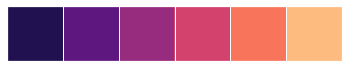

In [ ]:
palette = sns.color_palette("magma")
colors = [palette[0],palette[2], palette[4], palette[5]]
sns.set_palette(sns.color_palette(colors))

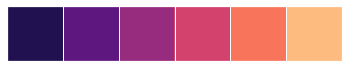

In [ ]:
classifier_list = list(saliency_metrics_dict["IG"]["CWRU"].keys())
experiment_list = ['Experiment3','Experiment106','Experiment105','Experiment104','Experiment103','Experiment102','Experiment101','Experiment6','Experiment4','Experiment5']

In [ ]:
# Create sanity df per saliency method

sanity_ssim_IG = pd.DataFrame(index = classifier_list, columns = experiment_list)
sanity_ssim_DL = pd.DataFrame(index = classifier_list, columns = experiment_list)
sanity_ssim_SHAP = pd.DataFrame(index = classifier_list, columns = experiment_list)
sanity_ssim_LIME = pd.DataFrame(index = classifier_list, columns = experiment_list)

sanity_structural_IG = pd.DataFrame(index = classifier_list, columns = experiment_list)
sanity_structural_DL = pd.DataFrame(index = classifier_list, columns = experiment_list)
sanity_structural_SHAP = pd.DataFrame(index = classifier_list, columns = experiment_list)
sanity_structural_LIME = pd.DataFrame(index = classifier_list, columns = experiment_list)

sanity_euclidean_IG = pd.DataFrame(index = classifier_list, columns = experiment_list)
sanity_euclidean_DL = pd.DataFrame(index = classifier_list, columns = experiment_list)
sanity_euclidean_SHAP = pd.DataFrame(index = classifier_list, columns = experiment_list)
sanity_euclidean_LIME = pd.DataFrame(index = classifier_list, columns = experiment_list)

for experiment in experiment_list:
    for classifier in classifier_list:

        if classifier == "AttentionLSTM":
            pass
       
        else:
            sanity_ssim_IG.loc[classifier, experiment] = (np.array(saliency_metrics_dict["IG"][experiment][classifier]['Sanity_ssim'])+1)/2 
            sanity_ssim_DL.loc[classifier, experiment] = (np.array(saliency_metrics_dict["DL"][experiment][classifier]['Sanity_ssim'])+1)/2   
            sanity_ssim_SHAP.loc[classifier, experiment] = (np.array(saliency_metrics_dict["SHAP"][experiment][classifier]['Sanity_ssim'])+1)/2   
            sanity_ssim_LIME.loc[classifier, experiment] = (np.array(saliency_metrics_dict["LIME"][experiment][classifier]['Sanity_ssim'])+1)/2   


In [ ]:
# Create faithfulness df per saliency method

faithfulness_TI_IG = pd.DataFrame(index = classifier_list, columns = experiment_list)
faithfulness_TI_DL = pd.DataFrame(index = classifier_list, columns = experiment_list)
faithfulness_TI_SHAP = pd.DataFrame(index = classifier_list, columns = experiment_list)
faithfulness_TI_LIME = pd.DataFrame(index = classifier_list, columns = experiment_list)

faithfulness_TS_IG = pd.DataFrame(index = classifier_list, columns = experiment_list)
faithfulness_TS_DL = pd.DataFrame(index = classifier_list, columns = experiment_list)
faithfulness_TS_SHAP = pd.DataFrame(index = classifier_list, columns = experiment_list)
faithfulness_TS_LIME = pd.DataFrame(index = classifier_list, columns = experiment_list)

for experiment in experiment_list:
    for classifier in classifier_list:
        faithfulness_TI_IG.loc[classifier, experiment] = saliency_metrics_dict["IG"][experiment][classifier]['Faithfulness_TI'] 
        faithfulness_TI_DL.loc[classifier, experiment] = saliency_metrics_dict["DL"][experiment][classifier]['Faithfulness_TI']  
        faithfulness_TI_SHAP.loc[classifier, experiment] = saliency_metrics_dict["SHAP"][experiment][classifier]['Faithfulness_TI']  
        faithfulness_TI_LIME.loc[classifier, experiment] = saliency_metrics_dict["LIME"][experiment][classifier]['Faithfulness_TI']  

    

In [ ]:
# aggregate dfs across experiments:

avg_sanity_ssim_per_exp = pd.DataFrame(columns = ["Sanity score", "Saliency method"])
avg_sanity_structural_per_exp = pd.DataFrame(columns = ["Sanity score", "Saliency method"])
avg_sanity_euclidean_per_exp = pd.DataFrame(columns = ["Sanity score", "Saliency method"])

avg_faithfulness_TI_per_exp = pd.DataFrame(columns = ["Faithfulness TI score", "Saliency method"])
avg_faithfulness_TS_per_exp = pd.DataFrame(columns = ["Faithfulness TS score", "Saliency method"])

for classifier in classifier_list:
    avg_sanity_ssim_per_exp = avg_sanity_ssim_per_exp.append(pd.DataFrame({"Sanity score": sanity_ssim_IG.loc[classifier,sanity_ssim_IG.columns != "CWRU"].values, "Saliency method": "IG"}, index=np.arange(10)))
    avg_sanity_ssim_per_exp = avg_sanity_ssim_per_exp.append(pd.DataFrame({"Sanity score": sanity_ssim_DL.loc[classifier,sanity_ssim_DL.columns != "CWRU"].values, "Saliency method": "DL"}, index=np.arange(10)))
    avg_sanity_ssim_per_exp = avg_sanity_ssim_per_exp.append(pd.DataFrame({"Sanity score": sanity_ssim_SHAP.loc[classifier,sanity_ssim_SHAP.columns != "CWRU"].values, "Saliency method": "SHAP"}, index=np.arange(10)))
    avg_sanity_ssim_per_exp = avg_sanity_ssim_per_exp.append(pd.DataFrame({"Sanity score": sanity_ssim_LIME.loc[classifier,sanity_ssim_LIME.columns != "CWRU"].values, "Saliency method": "LIME"}, index=np.arange(10)))

    avg_faithfulness_TI_per_exp = avg_faithfulness_TI_per_exp.append(pd.DataFrame({"Faithfulness TI score": faithfulness_TI_IG.loc[classifier,faithfulness_TI_IG.columns != "CWRU"].values, "Saliency method": np.repeat("IG", 10)}, index=np.arange(10)))
    avg_faithfulness_TI_per_exp = avg_faithfulness_TI_per_exp.append(pd.DataFrame({"Faithfulness TI score": faithfulness_TI_DL.loc[classifier,faithfulness_TI_DL.columns != "CWRU"].values, "Saliency method": np.repeat("DL", 10)}, index=np.arange(10)))
    avg_faithfulness_TI_per_exp = avg_faithfulness_TI_per_exp.append(pd.DataFrame({"Faithfulness TI score": faithfulness_TI_SHAP.loc[classifier,faithfulness_TI_SHAP.columns != "CWRU"].values, "Saliency method": np.repeat("SHAP", 10)}, index=np.arange(10)))
    avg_faithfulness_TI_per_exp = avg_faithfulness_TI_per_exp.append(pd.DataFrame({"Faithfulness TI score": faithfulness_TI_LIME.loc[classifier,faithfulness_TI_LIME.columns != "CWRU"].values, "Saliency method": np.repeat("LIME", 10)},index=np.arange(10)))

In [ ]:
TCN = "CNNClf_SaliencyGuidedTraining"
CNN = "CNNClf_SaliencyGuidedTraining"
Shapelet_experiments = ["Experiment3", "Experiment4", "Experiment5", "Experiment6"]

faith_per_concept_CNN = pd.DataFrame(columns = ["Faithfulness score", "Saliency method", "Type", "Concept"])
faith_per_concept_TCN = pd.DataFrame(columns = ["Faithfulness score", "Saliency method", "Type", "Concept"])

for exp in experiment_list:
    if exp in Shapelet_experiments:
        concept = "Shapelet"
    else:
        concept = "Latent"
    faith_per_concept_CNN = faith_per_concept_CNN.append(pd.DataFrame({"Faithfulness score": faithfulness_TI_IG.loc[CNN,faithfulness_TI_IG.columns == exp], "Saliency method": "IG", "Type": "TI", "Concept": concept}))
    faith_per_concept_CNN = faith_per_concept_CNN.append(pd.DataFrame({"Faithfulness score": faithfulness_TI_DL.loc[CNN,faithfulness_TI_DL.columns == exp], "Saliency method": "DL", "Type": "TI", "Concept": concept}))
    faith_per_concept_CNN = faith_per_concept_CNN.append(pd.DataFrame({"Faithfulness score": faithfulness_TI_LIME.loc[CNN,faithfulness_TI_LIME.columns == exp], "Saliency method": "LIME", "Type": "TI", "Concept": concept}))
    faith_per_concept_CNN = faith_per_concept_CNN.append(pd.DataFrame({"Faithfulness score": faithfulness_TI_SHAP.loc[CNN,faithfulness_TI_SHAP.columns == exp], "Saliency method": "SHAP", "Type": "TI", "Concept": concept}))

    faith_per_concept_TCN = faith_per_concept_TCN.append(pd.DataFrame({"Faithfulness score": faithfulness_TI_IG.loc[TCN,faithfulness_TI_IG.columns == exp], "Saliency method": "IG", "Type": "TI", "Concept": concept}))
    faith_per_concept_TCN = faith_per_concept_TCN.append(pd.DataFrame({"Faithfulness score": faithfulness_TI_DL.loc[TCN,faithfulness_TI_DL.columns == exp], "Saliency method": "DL", "Type": "TI", "Concept": concept}))
    faith_per_concept_TCN = faith_per_concept_TCN.append(pd.DataFrame({"Faithfulness score": faithfulness_TI_LIME.loc[TCN,faithfulness_TI_LIME.columns == exp], "Saliency method": "LIME", "Type": "TI", "Concept": concept}))
    faith_per_concept_TCN = faith_per_concept_TCN.append(pd.DataFrame({"Faithfulness score": faithfulness_TI_SHAP.loc[TCN,faithfulness_TI_SHAP.columns == exp], "Saliency method": "SHAP", "Type": "TI", "Concept": concept}))


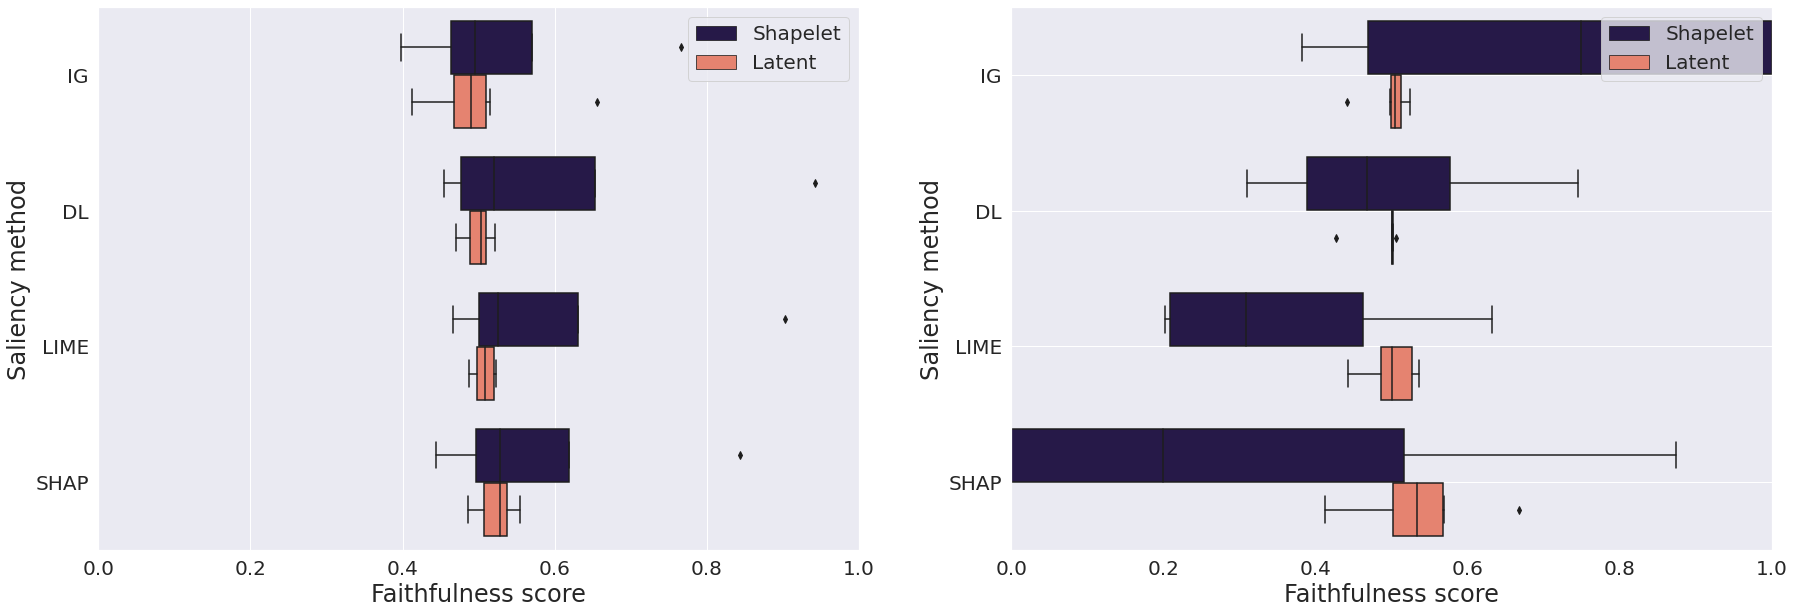

In [ ]:
palette = sns.color_palette("magma")
colors = [palette[0],palette[4]]
sns.set_palette(sns.color_palette(colors))

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (30,10))

faith_per_concept_CNN["Faithfulness score"] = 1+faith_per_concept_CNN["Faithfulness score"] 
faith_per_concept_TCN["Faithfulness score"] = 1+faith_per_concept_TCN["Faithfulness score"] 

sns.boxplot(data=faith_per_concept_CNN.loc[faith_per_concept_CNN["Type"]== "TI", :], x= "Faithfulness score", y = "Saliency method", hue = "Concept", ax = ax1)
ax1.set_xlim(0,1)
sns.boxplot(data=faith_per_concept_TCN.loc[faith_per_concept_TCN["Type"]== "TI", :], x= "Faithfulness score", y = "Saliency method", hue = "Concept", ax = ax2)
ax2.set_xlim(0,1)

ax1.xaxis.set_tick_params(labelsize=20)
ax2.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
plt.grid()

ax1.legend(prop={'size': 20})
ax2.legend(prop={'size': 20})
plt.show()

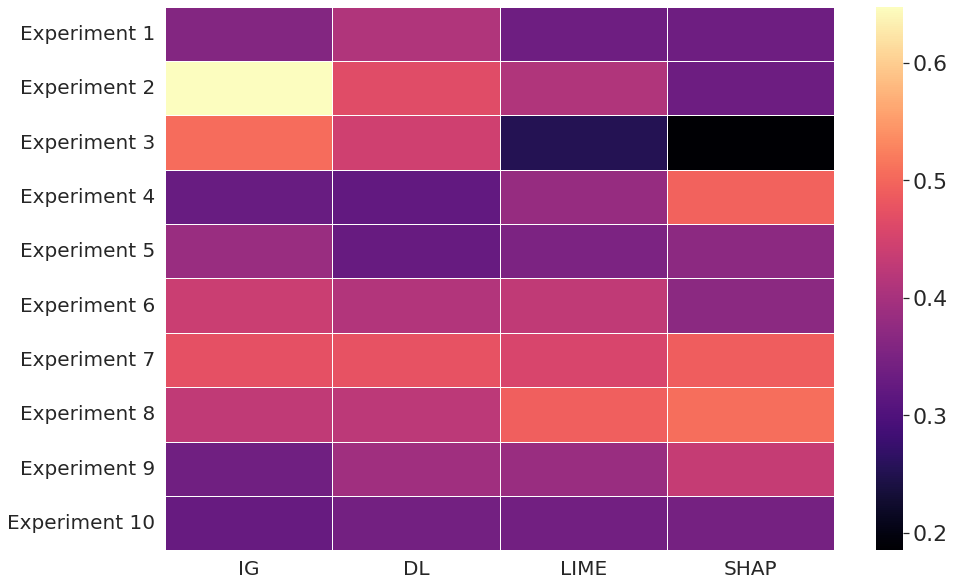

In [ ]:
# Create heatmap

faith_TI_agg = pd.DataFrame(columns = experiment_list)
faith_TI_agg = faith_TI_agg.append([1 + faithfulness_TI_IG.mean(axis = 0)])
faith_TI_agg = faith_TI_agg.append([1 + faithfulness_TI_DL.mean(axis = 0)])
faith_TI_agg = faith_TI_agg.append([1 + faithfulness_TI_LIME.mean(axis = 0)])
faith_TI_agg = faith_TI_agg.append([1 + faithfulness_TI_SHAP.mean(axis = 0)])
faith_TI_agg = faith_TI_agg.T
faith_TI_agg = faith_TI_agg.set_axis(["IG", "DL", "LIME", "SHAP"], axis = 1)


fig, ax1 = plt.subplots(figsize = (15,10))
sns.set(font_scale=2)
#plt.title("")
vmin = min(faith_TI_agg.values.min(), faith_TI_agg.values.min())
vmax = max(faith_TI_agg.values.max(), faith_TI_agg.values.max())

sns.heatmap(faith_TI_agg, ax=ax1, linewidth=.5, cmap = "magma")#, vmin=vmin,vmax=vmax)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

plt.show()

Create CNN+SGT plots for CWRU experiment


In [ ]:
experiment_name = "CWRU"
classifier_name = "CNNClf_SaliencyGuidedTraining"

acc = np.abs(saliency_metrics_dict["IG"][experiment_name][classifier_name]['Accuracy_ssim'])
ssim_IG = np.array(saliency_metrics_dict["IG"][experiment_name][classifier_name]['Similarities_ssim'])
ssim_DL = np.array(saliency_metrics_dict["DL"][experiment_name][classifier_name]['Similarities_ssim'])
ssim_SHAP = np.array(saliency_metrics_dict["SHAP"][experiment_name][classifier_name]['Similarities_ssim'])
ssim_LIME = np.array(saliency_metrics_dict["LIME"][experiment_name][classifier_name]['Similarities_ssim'])


accuracies = np.insert((1 -np.mean(acc, axis = 2).flatten()),0,1,axis = 0)
similarities_ssim_IG = np.insert(((ssim_IG+1)/2).flatten(),0,1,axis = 0)                      # scale possible distance from interval [-1,1] to interval [0,1]
similarities_ssim_DL = np.insert(((ssim_DL+1)/2).flatten(),0,1,axis = 0)     
similarities_ssim_SHAP = np.insert(((ssim_SHAP+1)/2).flatten(),0,1,axis = 0)     
similarities_ssim_LIME = np.insert(((ssim_LIME+1)/2).flatten(),0,1,axis = 0)     


/tmp/ipykernel_3670/3528108863.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(size = 15, labels =np.linspace(0, 100, 11) )


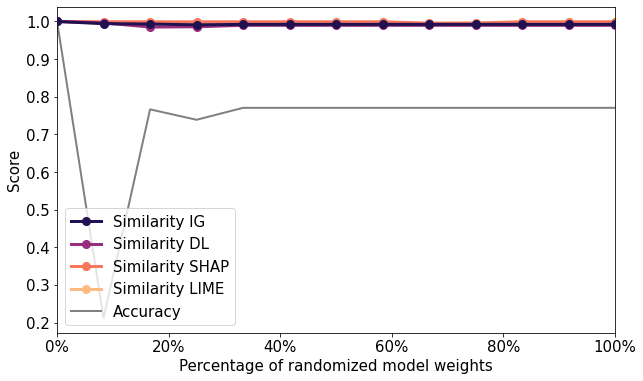

In [ ]:
import matplotlib.ticker as mtick

palette = sns.color_palette("magma")
colors = [palette[0],palette[2], palette[4], palette[5]]
sns.set_palette(sns.color_palette(colors))


fig = plt.figure(1, (10,6))
ax = fig.add_subplot(1,1,1)
x_range = np.linspace(0, 100, 13)

ax.plot(x_range, similarities_ssim_IG, marker='o', markersize=8, linewidth=3, label = "Similarity IG", zorder=4)
ax.plot(x_range, similarities_ssim_DL, marker='o', markersize=8, linewidth=3, label = "Similarity DL", zorder=3)
ax.plot(x_range, similarities_ssim_SHAP, marker='o', markersize=8, linewidth=3, label = "Similarity SHAP", zorder=2)
ax.plot(x_range, similarities_ssim_LIME, marker='o', markersize=8, linewidth=3, label = "Similarity LIME", zorder=1)

ax.plot(x_range, accuracies, marker='', color='grey', linewidth=2, label = "Accuracy")
ax.set_xlim(xmin=0, xmax = 100)

ax.set_xlabel("Percentage of randomized model weights", size = 15)
ax.set_ylabel("Score", size = 15)
ax.set_xticklabels(size = 15, labels =np.linspace(0, 100, 11) )
plt.yticks(fontsize=15)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.grid(color = "white")


plt.legend(loc = 3, prop={'size': 15})
plt.show()

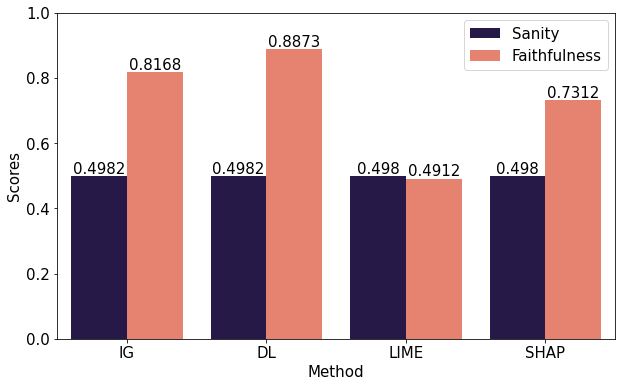

In [ ]:
s_IG = np.round((saliency_metrics_dict["IG"]["CWRU"]["CNNClf_SaliencyGuidedTraining"]["Sanity_ssim"]+1)/2, 4)
f_IG = np.round(1 + saliency_metrics_dict["IG"]["CWRU"]["CNNClf_SaliencyGuidedTraining"]["Faithfulness_TI"], 4)

s_DL = np.round((saliency_metrics_dict["DL"]["CWRU"]["CNNClf_SaliencyGuidedTraining"]["Sanity_ssim"]+1)/2,4)
f_DL = np.round(1 + saliency_metrics_dict["DL"]["CWRU"]["CNNClf_SaliencyGuidedTraining"]["Faithfulness_TI"],4)

s_LIME = np.round((saliency_metrics_dict["LIME"]["CWRU"]["CNNClf_SaliencyGuidedTraining"]["Sanity_ssim"]+1)/2,4)
f_LIME = np.round(1 + saliency_metrics_dict["LIME"]["CWRU"]["CNNClf_SaliencyGuidedTraining"]["Faithfulness_TI"],4)

s_SHAP = np.round((saliency_metrics_dict["SHAP"]["CWRU"]["CNNClf_SaliencyGuidedTraining"]["Sanity_ssim"]+1)/2,4)
f_SHAP = np.round(1 + saliency_metrics_dict["SHAP"]["CWRU"]["CNNClf_SaliencyGuidedTraining"]["Faithfulness_TI"],4)

df = pd.DataFrame({"Method": np.array(["IG", "DL", "LIME", "SHAP","IG", "DL", "LIME", "SHAP"]), "Scores": np.array([s_IG, s_DL, s_LIME, s_SHAP, f_IG, f_DL, f_LIME, f_SHAP]), 
                    "Type": np.array(["Sanity", "Sanity","Sanity","Sanity","Faithfulness", "Faithfulness", "Faithfulness", "Faithfulness"])})

colors = [palette[0],palette[4]]
sns.set_palette(sns.color_palette(colors))

fig, ax = plt.subplots(figsize = (10,6))

bar = sns.barplot(data = df, x = "Method", y = "Scores", hue = "Type")

ax.set_ylabel('Scores', size = 15)
ax.set_xlabel('Method', size = 15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
ax.set_ylim(ymin=0, ymax = 1)
for container in ax.containers:
    ax.bar_label(container, size = 15)
plt.legend(loc = 1, prop={'size': 15})

plt.show()
